In [13]:
import csv
#import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import snowflake.connector
import os
import numpy as np

In [3]:
# This chunk uses the snowflake-python connector to load comments db data into a dataframe if the csv does not exist
if os.path.exists("interactions.csv"):
    print("file exists, reloading dataframe")
    df_com = pd.read_csv("interactions.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                WITH
                NetworkMemberTotal as(
                SELECT
                ACCOUNT_ID,
                COUNT(NETWORK_MEMBER_UNIQUE_KEY) as TOTAL_MEMBERS
                FROM ANALYTICS.EDW_CE.NETWORK_MEMBER_HISTORICAL
                WHERE DAILY_LOGINS_LAST_180 > 0 AND NETWORK_NAME = 'Calix Community' AND LAST_RUN_AT_DATE = '2022-12-31'
                GROUP BY 1),

                NetworkMemberActive as(
                SELECT
                ACCOUNT_ID,
                COUNT(NETWORK_MEMBER_UNIQUE_KEY) as ACTIVE_MEMBERS
                FROM ANALYTICS.EDW_CE.NETWORK_MEMBER_HISTORICAL
                WHERE DAILY_LOGINS_LAST_90 > 0 AND NETWORK_NAME = 'Calix Community' AND LAST_RUN_AT_DATE = '2022-12-31'
                GROUP BY 1),

                CustomerActivities as (
                SELECT
                c.ACCOUNT_ID,
                COUNT(DISTINCT(ID)) as ACTIVITY_COUNT,
                COUNT(DISTINCT(CONTACT_ID)) as ACTIVITY_MEMBER_COUNT
                FROM ANALYTICS.EDW_CE.COMMUNITY_ACTIVITY c
                WHERE CREATED_DATE BETWEEN '2022-01-01' AND '2022-12-31'
                GROUP BY c.ACCOUNT_ID),

                Account AS
                (SELECT
                A.ACCOUNT_ID,
                A.ACCOUNT_ORACLE_ID
                FROM ANALYTICS.EDW_CE.ACCOUNT A),

                Combined AS (
                SELECT c.ACCOUNT_ID, ACCOUNT_ORACLE_ID, ACTIVITY_COUNT, ACTIVITY_MEMBER_COUNT, TOTAL_MEMBERS, ACTIVE_MEMBERS
                FROM CustomerActivities c
                LEFT JOIN NetworkMemberTotal nt ON c.ACCOUNT_ID = nt.ACCOUNT_ID
                LEFT JOIN NetworkMemberActive na ON c.ACCOUNT_ID = na.ACCOUNT_ID
                LEFT JOIN Account A ON c.ACCOUNT_ID = A.ACCOUNT_ID)

                SELECT * FROM COMBINED WHERE ACCOUNT_ORACLE_ID IS NOT NULL
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_com = pd.DataFrame(d, columns=cols)

    df_com.to_csv('interactions.csv')


Generating csv...
Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://calix.okta.com/app/snowflake/exk1fkyt56xzVeE891d8/sso/saml?SAMLRequest=jZJbj9owEIX%2FSuQ%2BEzuhl2ABqxCKmi3bIgi02zc3ccDCsVOPswn99XW4VNuHXfXNss%2FxNzNnxnddJb0nbkBoNUGBT5DHVa4LofYTtM0Wgwh5YJkqmNSKT9CJA7qbjoFVsqZxYw9qzX81HKznPlJA%2B4cJaoyimoEAqljFgdqcbuKHJQ19QhkAN9bh0NVSgHCsg7U1xbhtW78d%2BtrscUgIwWSEnaqXvEHPEPXrjNpoq3Mtb5bO9fQCIsDkbY9wCkdYXY0zoS4jeI3y8yIC%2BinLVoPV102GvPjWXaIVNBU3G26eRM636%2BWlAHAVJPEy%2Fe6D0m0p2ZHnuqob637y3QmXvMBS74WbTzqfoPooihlJmVnfZ0U4D6LHhUnLRNzvdvn2EHzrtgmL9wexUPWs%2BvyYI293SzPs00wBGp6qPkPrrkg4HJBoQEZZENFwRMnQj0YffiBv7jIUitmz81ZozqTofH207Fwaq2v8t2rMu2NQHk%2F23fvu945%2FjEZBEWEAjfuA0GVH6Blvpv%2FT%2BRg%2Fd1xX7IubejpfaSnyk7fQpmL25VACPzjfiGJQnqWUV0zIuCgMB3DhSKnbxHBm3SZb03CEpxfqv7s8%2FQM%3D&RelayState=51

In [4]:
# This chunk uses the snowflake-python connector to load seployments db data into a dataframe if the csv does not exist
if os.path.exists("deployments.csv"):
    print("file exists, reloading dataframe") 
    df_dep = pd.read_csv("deployments.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                SELECT
                G.SNAPSHOT_DATE,
                G.ORG_ID,
                G.ORACLE_ID,
                A.ACCOUNT_NAME,
                G.SOFTWARE_VERSION,
                G.MODEL_NAME,
                G.SKU,
                G.PREMISE_SUBTYPE, 
                G.GS_30_DAYS_COUNT, 
                G.GS_ALL_TIME_COUNT,
                G.GATEWAY_30_DAYS_COUNT as GS_SUBSCRIBERS
                FROM
                "ANALYTICS"."EDW_CE"."GIGASPIRE_DEPLOYMENTS_HISTORICAL" G
                LEFT JOIN "ANALYTICS"."EDW_CE"."ACCOUNT" A ON ORACLE_ID = A.ACCOUNT_ORACLE_ID
                WHERE 
                (G.PREMISE_TYPE = 'GigaSpire' OR G.PREMISE_TYPE = 'GigaSpire - DTM')
                AND G.SNAPSHOT_DATE = '2022-12-31'
                AND ORACLE_ID IS NOT NULL
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_dep = pd.DataFrame(d, columns=cols)

    df_dep.to_csv('deployments.csv')

Generating csv...


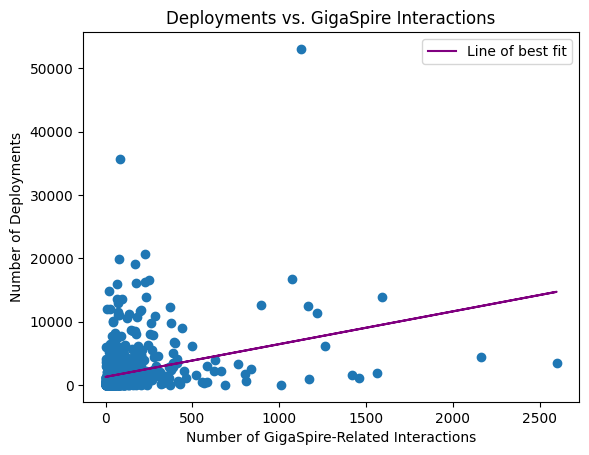

In [18]:
#Primary Visualization for Total Interactions

dep_agg = df_dep.groupby(by=['ORACLE_ID']).GS_ALL_TIME_COUNT.sum().reset_index()
com_agg = df_com.groupby(by=['ACCOUNT_ORACLE_ID']).sum().reset_index()[['ACCOUNT_ORACLE_ID', 'ACTIVITY_COUNT']]


dep_agg["ORACLE_ID"] = dep_agg["ORACLE_ID"].astype(float)
com_agg["ACCOUNT_ORACLE_ID"] = com_agg["ACCOUNT_ORACLE_ID"].astype(float)


total = pd.merge(dep_agg, com_agg, left_on='ORACLE_ID', right_on='ACCOUNT_ORACLE_ID')

plt.clf()
plt.figs
a, b = np.polyfit(total["ACTIVITY_COUNT"], total["GS_ALL_TIME_COUNT"], 1)
plt.scatter(total["ACTIVITY_COUNT"], total["GS_ALL_TIME_COUNT"])
plt.plot(total["ACTIVITY_COUNT"], a*total["ACTIVITY_COUNT"]+b, color='purple', label='Line of best fit')
plt.legend()
plt.xlabel("Number of GigaSpire-Related Interactions")
plt.ylabel("Number of Deployments")
plt.title("Deployments vs. GigaSpire Interactions")
plt.savefig("Deployments_vs._GigaSpire_Interactions.png")

In [1]:
# Visualizations for overall interactions

roles = ["Manager", "Specialist", 'Engineer', 'Technician']
functions = ["Marketing", "Sales", 'Operations']

for role in roles:
    for function in functions:

        dep_agg = df_dep.groupby(by=['ORACLE_ID']).GS_ALL_TIME_COUNT.sum().reset_index()
        com_agg = df_com.groupby(by=['ACCOUNT_ORACLE_ID', 'LEVEL', 'FUNCTION']).count().reset_index()[['ACCOUNT_ORACLE_ID', 'ID', 'LEVEL', "FUNCTION"]]
        com_agg = com_agg.query("LEVEL=='"+role+"' & FUNCTION=='"+function+"'")
        
        dep_agg["ORACLE_ID"] = dep_agg["ORACLE_ID"].astype(float)
        com_agg["ACCOUNT_ORACLE_ID"] = com_agg["ACCOUNT_ORACLE_ID"].astype(float)

        total = pd.merge(dep_agg, com_agg, left_on='ORACLE_ID', right_on='ACCOUNT_ORACLE_ID')

        plt.clf()
        plt.scatter(total["ID"], total["GS_ALL_TIME_COUNT"])
        plt.xlabel("Number of "+function+" "+role+" Comments")
        plt.ylabel("Number of Deployments")
        plt.title("Deployments vs. "+function+" "+role+" Comments")
        plt.savefig(""+function+"_"+role+"_Deployments_vs._Comments.png")


NameError: name 'df_dep' is not defined

In [ ]:
# Visualizations for comments and posts

df_topic = df_com[df_com['TOPIC_NAME'].str.contains("GigaSpire|Gigaspire|GigaCenter|Gigecenter|Gigaspre|Gigafamily|GigaGamily|Giga Spire|GIgaSpire")]

df_comments = df_topic[df_topic['ENTITY_TYPE'].str.contains("Comment")]

dep_agg = df_dep.groupby(by=['ORACLE_ID']).GS_ALL_TIME_COUNT.sum().reset_index()
com_agg = df_comments.groupby(by=['ACCOUNT_ORACLE_ID']).count().reset_index()[['ACCOUNT_ORACLE_ID', 'ID']]

dep_agg["ORACLE_ID"] = dep_agg["ORACLE_ID"].astype(float)
com_agg["ACCOUNT_ORACLE_ID"] = com_agg["ACCOUNT_ORACLE_ID"].astype(float)


total = pd.merge(dep_agg, com_agg, left_on='ORACLE_ID', right_on='ACCOUNT_ORACLE_ID')


plt.clf()
plt.scatter(total["ID"], total["GS_ALL_TIME_COUNT"])
plt.xlabel("Number of GigaSpire-Related Comments")
plt.ylabel("Number of Deployments")
plt.title("Deployments vs. GigaSpire Comments")
plt.savefig("Deployments_vs._GigaSpire_Comments.png")



C:\Users\nmathur\AppData\Local\Temp\ipykernel_11592\3326929472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_agg["NORMALIZED_INTS"] = com_agg["ACTIVITY_COUNT"] / com_agg["ACTIVITY_MEMBER_COUNT"]
C:\Users\nmathur\AppData\Local\Temp\ipykernel_11592\3326929472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_agg["ACCOUNT_ORACLE_ID"] = com_agg["ACCOUNT_ORACLE_ID"].astype(int)


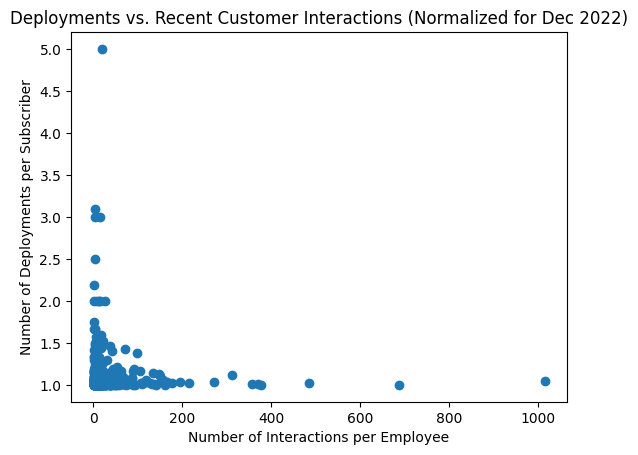

In [14]:
# Visualizations for normalization

# Deployments
dep_count = df_dep.groupby(by=['ORACLE_ID']).GS_30_DAYS_COUNT.sum().reset_index()
dep_subs = df_dep.groupby(by=['ORACLE_ID']).GS_SUBSCRIBERS.sum().reset_index()

dep_agg = pd.merge(dep_count, dep_subs, left_on='ORACLE_ID', right_on='ORACLE_ID')
dep_agg['NORMALIZED_DEPS'] = dep_agg["GS_30_DAYS_COUNT"] / dep_agg["GS_SUBSCRIBERS"]

# Comments
com_agg = df_com.query("TOTAL_MEMBERS > 0 & ACCOUNT_ORACLE_ID != 'None'")
com_agg["NORMALIZED_INTS"] = com_agg["ACTIVITY_COUNT"] / com_agg["ACTIVITY_MEMBER_COUNT"]

dep_agg["ORACLE_ID"] = dep_agg["ORACLE_ID"].astype(int)
com_agg["ACCOUNT_ORACLE_ID"] = com_agg["ACCOUNT_ORACLE_ID"].astype(int)

total = pd.merge(dep_agg, com_agg, left_on='ORACLE_ID', right_on='ACCOUNT_ORACLE_ID')

plt.clf()
plt.scatter(total["NORMALIZED_INTS"], total["NORMALIZED_DEPS"])
plt.xlabel("Number of Interactions per Employee")
plt.ylabel("Number of Deployments per Subscriber")
plt.title("Deployments vs. Recent Customer Interactions (Normalized for Dec 2022)")
plt.savefig("Recent_Norm_Interactions_vs_GS_Deployments_30DAY.png")
